[[1.02397544e+00 1.33697692e+03]
 [1.02397544e+00 1.33697692e+03]
 [1.02397544e+00 1.33697692e+03]
 ...
 [1.04897336e+00 1.39123144e+03]
 [1.04897336e+00 1.39123144e+03]
 [1.04897336e+00 1.39123144e+03]]
[334.0892335670755, 333.9987977049098, 334.2796920041318, 334.6201036253088, 334.21439490790056, 335.2617976743251, 341.9484901533041, 364.2656398055081]
[375.24773387782096, 375.19524619201854, 375.15609342090505, 375.2001246428878, 375.3058869125934, 375.9330636531289, 382.6207861777669, 416.3286386578587]
[415.8941759864596, 416.0494112269902, 415.7795926467139, 416.0902593715306, 415.9823190622862, 416.89507982333197, 423.7075111518034, 466.22333293975987]


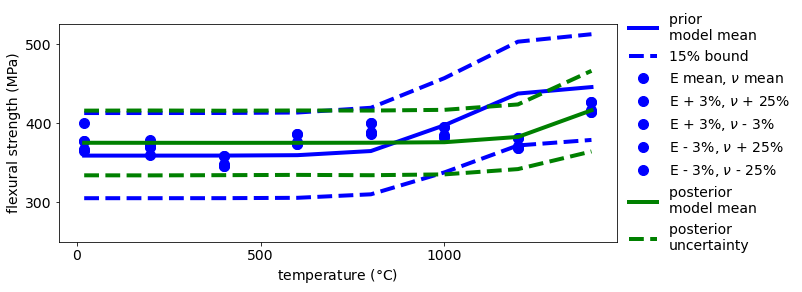

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import pickle

#centered_synth_exp = [341.34307562, 343.39421741, 332.72204114, 370.54835985, 
#                      347.52350974, 400.16028132, 432.76704837, 417.17647725, 425.15201902]
#shifted_up_exp = [371.93923856, 422.0748083, 360.47125363, 407.79689099, 380.09236394,
#            417.76626157, 444.91269431, 459.29178947, 478.02731897]
#shifted_down_exp = [303.78800408, 317.47338596, 351.81246919, 333.06652442, 343.87121988, 
#                    393.48889663, 401.80579517, 424.7875635, 433.83970035]
#shifted_left_synth_exp = [349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
#                          441.0380559, 448.98198769, 435.41553941, 451.91814983]

class ip:
    # Q (for proposal samples).  
    # Initialize experimental data.
    mcmc_length = 250000
    mcmc_burn_in = 10000 # number of samples
    mu_prior = np.array([1.0, 1020.67])
    cov_prior = np.array([[1, 0.0],
                          [0.0, np.power(500.0,2)]])

    FEM_E_1_nu_1 = np.array([367.194, 359.245, 348.176, 376.061, 389.298, 384.541, 370.627, 416.84])
    FEM_E_103_nu_125 = np.array([377.6519, 369.4793, 358.1044, 386.6456, 400.1605, 395.2744, 381.0115, 427.1622])
    FEM_E_103_nu_75 = np.array([364.6897, 378.7448, 345.8915, 373.7281, 387.0204, 382.3514, 368.5415, 413.7958])
    FEM_E_97_nu_125 = np.array([377.5945, 369.4181, 358.0498, 386.5902, 400.0995, 395.2197, 380.9568, 427.113])
    FEM_E_97_nu_75 = np.array([400.1368, 372.3877, 345.8431, 373.6837, 386.9683, 382.3074, 368.4869, 413.744])
   
    Q_mu = np.array([0, 0])
    Q_cov = cov_prior#np.array([[0.01, 0.0],
                          #[0.0, np.power(500.0,2)]]) #cov_prior
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,2)) 
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods_vec = np.zeros((self.mcmc_length,1))
        posteriors_un_normed_vec = np.zeros((self.mcmc_length,1))
        priors_vec = np.zeros((self.mcmc_length,1))
        for i in range(1,self.mcmc_length):
            proposal_sample = samples[i-1,:] + np.random.multivariate_normal(self.Q_mu,self.Q_cov)
            prior_proposal = self.prior(proposal_sample)
            likelihood_proposal = self.likelihood(proposal_sample)
            prior_current_location = self.prior(samples[i-1,:])
            likelihood_current_location = self.likelihood(samples[i-1,:])
            accept_pro = (likelihood_proposal*prior_proposal)/(likelihood_current_location*prior_current_location)
            uni_rand = np.random.uniform()
            if uni_rand<accept_pro:
                samples[i,:] = proposal_sample
                posteriors_un_normed_vec[i] = likelihood_proposal*prior_proposal
                likelihoods_vec[i] = likelihood_proposal
                priors_vec[i] = prior_proposal
            else:
                samples[i,:] = samples[i-1,:]
                posteriors_un_normed_vec[i] = likelihood_current_location*prior_current_location
                likelihoods_vec[i] = likelihood_current_location
                priors_vec[i] = prior_current_location
            ########################################
        samples = samples[self.mcmc_burn_in:]
        posteriors_un_normed_vec = posteriors_un_normed_vec[self.mcmc_burn_in:]
        likelihoods_vec = likelihoods_vec[self.mcmc_burn_in:]
        priors_vec = priors_vec[self.mcmc_burn_in:]
        #posterior probabilites are transformed to a standard normal (std=1)
        #for obtaining the evidence:
        evidence = np.mean(posteriors_un_normed_vec)*np.sqrt(2*np.pi*np.std(samples)**2)
        posteriors_vec = posteriors_un_normed_vec/evidence
        log_ratios = np.log(posteriors_vec/priors_vec)
        log_ratios[np.isinf(log_ratios)] = 0
        log_ratios = np.nan_to_num(log_ratios)
        info_gain = np.mean(log_ratios)
        return [evidence, info_gain, samples]
    
    def prior(self,sample):
        probability = multivariate_normal.pdf(x=sample, mean=self.mu_prior, cov=self.cov_prior, allow_singular=False)
        return probability
        
    def likelihood(self,sample): # The model goes in here
        FEM_temp = np.array([20, 200, 400, 600, 800, 1000, 1200, 1400])
        FS_array = (359+87.6/(1+np.exp(-0.012*(FEM_temp-sample[1]))))*sample[0]
        #print(np.square(FS_array - self.FEM_E_1_nu_1))
        #print(np.sum(np.square(FS_array - self.FEM_E_1_nu_1))/8)
        SSE_E_1_nu_1 = np.sum(np.square(FS_array - self.FEM_E_1_nu_1))/8 #E is Young's modulus
        SSE_E_103_nu_125 = np.sum(np.square(FS_array - self.FEM_E_103_nu_125))/8
        SSE_E_103_nu_75 = np.sum(np.square(FS_array - self.FEM_E_103_nu_75))/8
        SSE_E_97_nu_125 = np.sum(np.square(FS_array - self.FEM_E_97_nu_125))/8
        SSE_E_97_nu_75 = np.sum(np.square(FS_array - self.FEM_E_97_nu_75))/8
        SSE = np.sum([SSE_E_1_nu_1,SSE_E_103_nu_125,SSE_E_103_nu_75,SSE_E_97_nu_125,
                 SSE_E_97_nu_75])
        #print(SSE)
        probability_ra = np.exp(-SSE/225)#multivariate_normal.pdf(x=SSE,mean=0, cov=625)  
        #print(probability_ra)
        return probability_ra
#-------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------
 

evidences=[]
info_gains=[]
all_samples=[]

ip_object = ip()

[evidence, info_gain, samples] = ip_object.MetropolisHastings()
#evidences.append(evidence)
#info_gains.append(info_gain)
#all_samples.append(samples)
#print('Evidence: ' + str(evidence))
#print('Information Gain: ' + str(info_gain))
#print('Samples: ' +str(samples))
#print(samples.shape)  
#evidencearray = np.asarray(evidences)
#print('evidence shape')
#print(evidencearray.shape)

T = np.array([20, 200, 400, 600, 800, 1000, 1200, 1400])

FS_upper_bound = []
FS_lower_bound = []
FS_mean = []
FS_temp = np.zeros((len(samples),1))
print(samples)
for temp in T:
    for i in range(len(samples)):
        #print(samples[i,1])
        FS_temp[i,0] = (359+87.6/(1+np.exp(-0.012*(temp-samples[i,1]))))*samples[i,0]
    #for i in FS_temp:
    #    FS_temp[i] = FS_temp[i] + 10*np.random.randn()
    #print(10*np.random.randn(len(FS_temp),1))
    FS_temp_total = FS_temp + 15*np.random.randn(len(FS_temp),1)
    #print(FS_temp)
    #print(FS_temp_total)
    FS_temp_total_sorted = np.sort(FS_temp_total, axis=0)
    #print(FS_temp_total.shape)
    #print(FS_temp_total_sorted)
    #print(int(np.round(0.05*len(FS_temp))))
    #print(int(np.round(0.95*len(FS_temp))))
    #print(int(np.round(0.5*len(FS_temp))))
    FS_lower_bound.append(FS_temp_total_sorted[int(np.round(0.005*len(FS_temp))),0])
    FS_upper_bound.append(FS_temp_total_sorted[int(np.round(0.995*len(FS_temp))),0])
    FS_mean.append(FS_temp_total_sorted[int(np.round(0.5*len(FS_temp))),0])
#print(samples)
print(FS_lower_bound)
print(FS_mean)
print(FS_upper_bound)

synth_exp = np.array([349.95490152, 355.89666548, 410.05829427, 393.77353699, 421.84752866,
                          441.0380559, 448.98198769, 435.41553941, 451.91814983])  

FS = 359+87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_upper_15_percent = 1.15*359+1.15*87.6/(1+np.exp(-0.012*(T-1020.67)))
FS_lower_15_percent = 0.85*359+0.85*87.6/(1+np.exp(-0.012*(T-1020.67)))

FEM_temp = np.array([20, 200, 400, 600, 800, 1000, 1200, 1400])
FEM_E_1_nu_1 = np.array([367.194, 359.245, 348.176, 376.061, 389.298, 384.541, 370.627, 416.84])
FEM_E_103_nu_125 = np.array([377.6519, 369.4793, 358.1044, 386.6456, 400.1605, 395.2744, 381.0115, 427.1622])
FEM_E_103_nu_75 = np.array([364.6897, 378.7448, 345.8915, 373.7281, 387.0204, 382.3514, 368.5415, 413.7958])
FEM_E_97_nu_125 = np.array([377.5945, 369.4181, 358.0498, 386.5902, 400.0995, 395.2197, 380.9568, 427.113])
FEM_E_97_nu_75 = np.array([400.1368, 372.3877, 345.8431, 373.6837, 386.9683, 382.3074, 368.4869, 413.744]) 

plt.figure(figsize=(10,4))
plt.plot(T,FS,'b',linewidth=4, label = 'prior \nmodel mean')
plt.plot(T,FS_upper_15_percent,'b--',linewidth=4, label = '15% bound')
plt.plot(T,FS_lower_15_percent,'b--',linewidth=4)
plt.plot(FEM_temp, FEM_E_1_nu_1, 'bo', markersize=10, label = r'E mean, $\nu$ mean')#, label = r'E mean, $\nu$ mean'
plt.plot(FEM_temp, FEM_E_103_nu_125, 'b^', markersize=10,label = r'E + 3%, $\nu$ + 25%')#, label = r'E + 3%, $\nu$ + 25%'
plt.plot(FEM_temp, FEM_E_103_nu_75, 'bx', markersize=10,label = r'E + 3%, $\nu$ - 3%')#, label = r'E + 3%, $\nu$ - 3%'
plt.plot(FEM_temp, FEM_E_97_nu_125, 'b+', markersize=10, label = r'E - 3%, $\nu$ + 25%')#, label = r'E - 3%, $\nu$ + 25%'
plt.plot(FEM_temp, FEM_E_97_nu_75, 'bv', markersize=10, label = r'E - 3%, $\nu$ - 25%') #, label = r'E - 3%, $\nu$ - 25%'
plt.plot(T,FS_mean,'g',linewidth=4,label = 'posterior \nmodel mean')
plt.plot(T,FS_upper_bound,'g--',linewidth=4, label = 'posterior \nuncertainty')
plt.plot(T,FS_lower_bound,'g--',linewidth=4)
#plt.plot(T,synth_exp,'bo',label = 'synthetic \nexperimental data') #standard deviation 20 MPa
plt.ylim([250,525])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
#plt.legend(loc='upper left')
plt.ylabel(r'flexural strength (MPa)')
plt.xlabel(r'temperature ($\degree$C)')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.savefig('Bayes_flexural_strength_FEM.png',dpi=300,bbox_inches='tight')


bound =  [0.10831895 0.10888775 0.10828426 0.1089822  0.10838208 0.10896093
 0.10738237 0.11984449]
R squared posterior=  0.5804323410407166
R squared prior=  -1.352273161913938


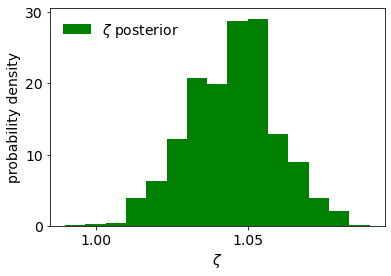

In [2]:
FEM_mean_5_points = np.array([377.45338, 369.85498, 351.21296, 379.34172, 392.70934, 
                              387.93878, 373.92474, 419.731])
FS_upper_bound = np.array(FS_upper_bound)
FS_mean = np.array(FS_mean)
print("bound = ", (FS_upper_bound - FS_mean) / FS_mean)
SSE = np.sum(np.power(FS_mean - FEM_mean_5_points,2))
TSS = np.sum(np.power(FEM_mean_5_points - np.mean(FEM_mean_5_points),2))
print("R squared posterior= ", 1 - SSE/TSS)
SSE_pri = np.sum(np.power(FS - FEM_mean_5_points,2))
print("R squared prior= ", 1 - SSE_pri/TSS)
zeta_prior = 1 + np.random.randn(40000)
zeta_post = samples[:,0].flatten()
plt.hist(zeta_post,label=r'$\zeta$ posterior',color='g',bins=15,density=True)
plt.xlabel(r'$\zeta$')
plt.ylabel(r'probability density')
plt.legend(frameon=False)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.savefig('Bayes_zeta_param_FEM.png',dpi=300,bbox_inches='tight')


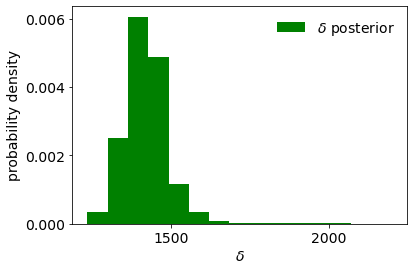

In [3]:
delta_post = samples[:,1].flatten()
plt.hist(delta_post,label=r'$\delta$ posterior',color='g',bins=15,density=True)
plt.xlabel(r'$\delta$')
plt.ylabel(r'probability density')
plt.legend(frameon=False)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.savefig('Bayes_delta_param_FEM.png',dpi=300,bbox_inches='tight')


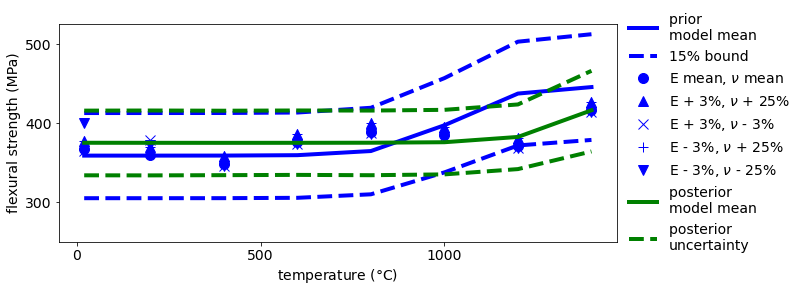

In [4]:
plt.figure(figsize=(10,4))
plt.plot(T,FS,'b',linewidth=4, label = 'prior \nmodel mean')
plt.plot(T,FS_upper_15_percent,'b--',linewidth=4, label = '15% bound')
plt.plot(T,FS_lower_15_percent,'b--',linewidth=4)
plt.plot(FEM_temp, FEM_E_1_nu_1, 'bo', markersize=10, label = r'E mean, $\nu$ mean')#, label = r'E mean, $\nu$ mean'
plt.plot(FEM_temp, FEM_E_103_nu_125, 'b^', markersize=10,label = r'E + 3%, $\nu$ + 25%')#, label = r'E + 3%, $\nu$ + 25%'
plt.plot(FEM_temp, FEM_E_103_nu_75, 'bx', markersize=10,label = r'E + 3%, $\nu$ - 3%')#, label = r'E + 3%, $\nu$ - 3%'
plt.plot(FEM_temp, FEM_E_97_nu_125, 'b+', markersize=10, label = r'E - 3%, $\nu$ + 25%')#, label = r'E - 3%, $\nu$ + 25%'
plt.plot(FEM_temp, FEM_E_97_nu_75, 'bv', markersize=10, label = r'E - 3%, $\nu$ - 25%') #, label = r'E - 3%, $\nu$ - 25%'
plt.plot(T,FS_mean,'g',linewidth=4,label = 'posterior \nmodel mean')
plt.plot(T,FS_upper_bound,'g--',linewidth=4, label = 'posterior \nuncertainty')
plt.plot(T,FS_lower_bound,'g--',linewidth=4)
#plt.plot(T,synth_exp,'bo',label = 'synthetic \nexperimental data') #standard deviation 20 MPa
plt.ylim([250,525])
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
#plt.legend(loc='upper left')
plt.ylabel(r'flexural strength (MPa)')
plt.xlabel(r'temperature ($\degree$C)')
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=6)
plt.savefig('Bayes_flexural_strength_FEM.png',dpi=300,bbox_inches='tight')
